# Assignment Module 2: Pet Classification

The goal of this assignment is to implement a neural network that classifies images of 37 breeds of cats and dogs from the [Oxford-IIIT-Pet dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). The assignment is divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.


## Dataset

The following cells contain the code to download and access the dataset you will be using in this assignment. Note that, although this dataset features each and every image from [Oxford-IIIT-Pet](https://www.robots.ox.ac.uk/~vgg/data/pets/), it uses a different train-val-test split than the original authors.


In [ ]:
!git clone https://github.com/CVLAB-Unibo/ipcv-assignment-2.git

fatal: destination path 'ipcv-assignment-2' already exists and is not an empty directory.


In [3]:
import os
import math
from pathlib import Path
from PIL import Image
from torch import Tensor
import torch
from torchinfo import summary
from torch.utils.data import Dataset
from typing import List, Tuple
import matplotlib.pyplot as plt
import wandb
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import torch.nn.functional as F
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)
from tqdm.auto import tqdm


BATCH_SIZE = 128

c:\Users\mpred\miniconda3\envs\ipcv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Login into wandb
API = '287da622db71b3c4376edca2ab62b34407fb7070'
wandb.login(API)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\mpred\_netrc
wandb: Currently logged in as: mpreda01 (mpreda01-universit-di-bologna) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
LABELS_TO_NAME = {
    0: "Abyssinian",
    1: "american_bulldog",
    2: "american_pit_bull_terrier",
    3: "basset_hound",
    4: "beagle",
    5: "Bengal",
    6: "Birman",
    7: "Bombay",
    8: "boxer",
    9: "British_Shorthair",
    10: "chihuahua",
    11: "Egyptian_Mau",
    12: "english_cocker_spaniel",
    13: "english_setter",
    14: "german_shorthaired",
    15: "great_pyrenees",
    16: "havanese",
    17: "japanese_chin",
    18: "keeshond",
    19: "leonberger",
    20: "Maine_Coon",
    21: "miniature_pinscher",
    22: "newfoundland",
    23: "Persian",
    24: "pomeranian",
    25: "pug",
    26: "Ragdoll",
    27: "Russian_Blue",
    28: "saint_bernard",
    29: "samoyed",
    30: "scottish_terrier",
    31: "shiba_inu",
    32: "Siamese",
    33: "Sphynx",
    34: "staffordshire_bull_terrier",
    35: "wheaten_terrier",
    36: "yorkshire_terrier",
}

NUM_CLASSES = 37


class OxfordPetDataset(Dataset):
    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("ipcv-assignment-2") / "dataset"
        self.split = split
        self.names, self.labels = self._get_names_and_labels()
        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img_path = self.root / "images" / f"{self.names[idx]}.jpg"
        img = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

    def _get_names_and_labels(self) -> Tuple[List[str], List[int]]:
        names = []
        labels = []

        with open(self.root / "annotations" / f"{self.split}.txt") as f:
            for line in f:
                name, label = line.replace("\n", "").split(" ")
                names.append(name),
                labels.append(int(label) - 1)

        return names, labels

## Data Inspection


In [6]:
preprocess = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

train_dataset = OxfordPetDataset("train", transform=preprocess)
val_dataset = OxfordPetDataset("val", transform=preprocess)
test_dataset = OxfordPetDataset("test", transform=preprocess)

train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dl = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

The train dataset contains 3669
The test dataset contains 1834
The train dataset contains 1846


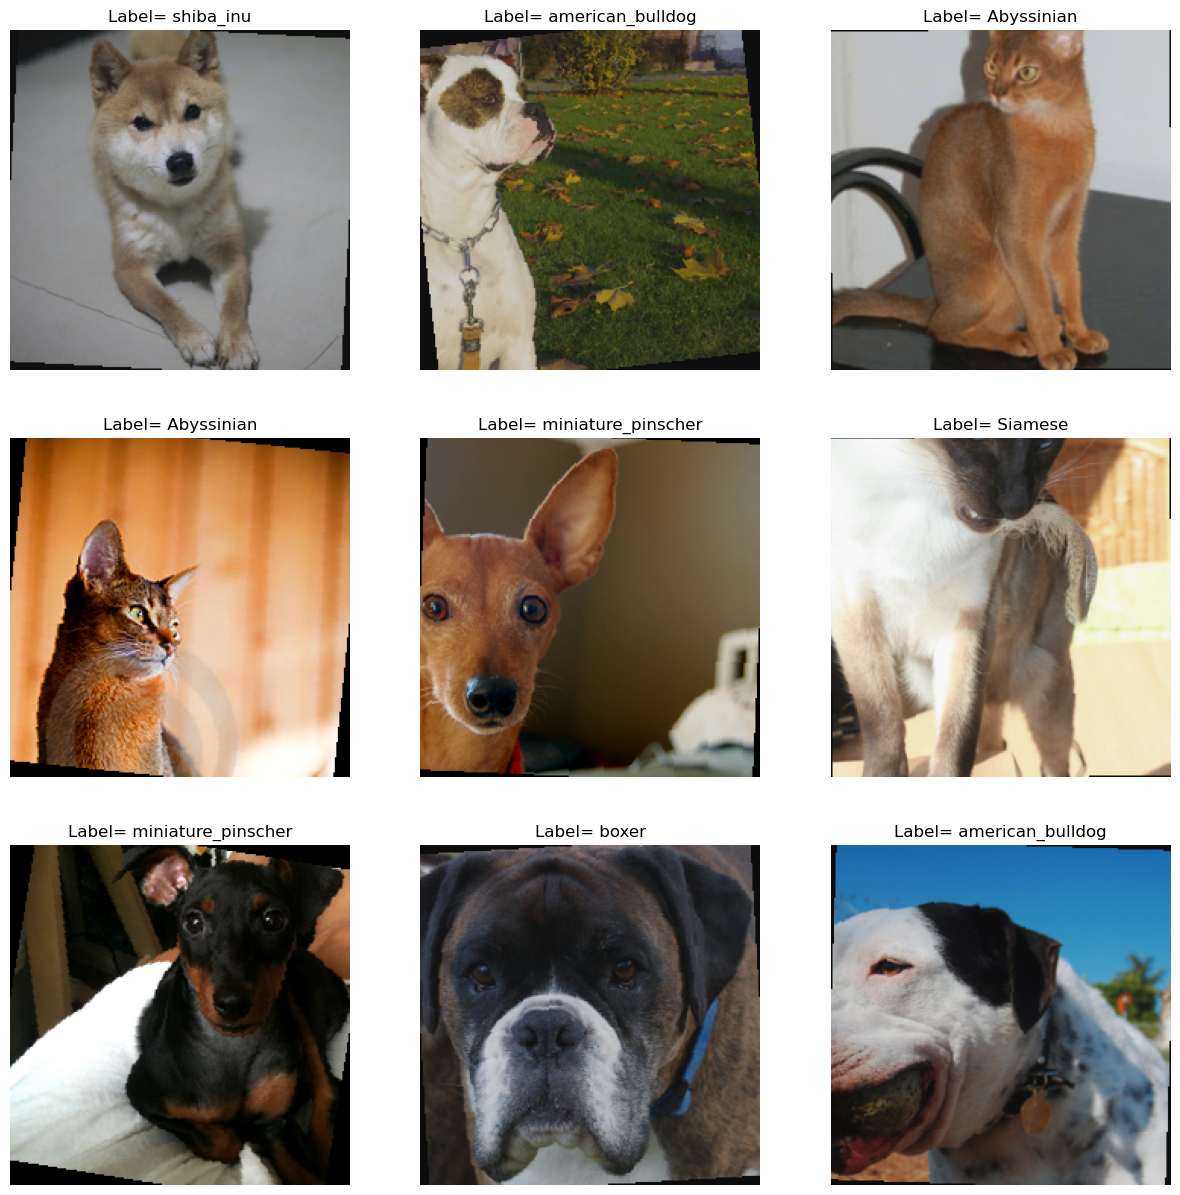

In [7]:
def denorm_image(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """
    Denormalize a tensor image (C, H, W) or (B, C, H, W) that was normalized
    using torchvision's Normalize(mean, std).
    """
    if tensor.ndim == 3:
        mean = torch.tensor(mean, device=tensor.device).view(-1, 1, 1)
        std = torch.tensor(std, device=tensor.device).view(-1, 1, 1)
    elif tensor.ndim == 4:
        mean = torch.tensor(mean, device=tensor.device).view(1, -1, 1, 1)
        std = torch.tensor(std, device=tensor.device).view(1, -1, 1, 1)
    else:
        raise ValueError("Expected tensor of shape (C,H,W) or (B,C,H,W)")

    return tensor * std + mean


print(f"The train dataset contains {len(train_dataset)}")
print(f"The test dataset contains {len(val_dataset)}")
print(f"The train dataset contains {len(test_dataset)}")
indexes = torch.randperm(len(train_dataset))[:9]
plt.figure(figsize=(15, 15))
for ind, i in enumerate(indexes):
    img, label = train_dataset[i]
    plt.subplot(3, 3, ind + 1)
    plt.imshow(denorm_image(img).permute(1, 2, 0))
    plt.title(f"Label= {LABELS_TO_NAME[label]}")
    plt.axis("off")

## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it from scratch on `OxfordPetDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the test split of ~60%. You are free to achieve this however you want, except for a few rules you must follow:

- Compile this notebook by displaying the results obtained by the best model you found throughout your experimentation; then show how, by removing some of its components, its performance drops. In other words, do an _ablation study_ to prove that your design choices have a positive impact on the final result.

- Do not instantiate an off-the-self PyTorch network. Instead, construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you cannot use e.g. `torchvision.models.alexnet`.

- Show your results and ablations with plots, tables, images, etc. — the clearer, the better.

Don't be too concerned with your model performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded more points than a poorly experimentally validated model with higher accuracy.


## Block definition for the net

In [14]:
class conv_block(nn.Module):
    def __init__(self, in_channels, num_filters):
        super().__init__()
        # Two convolutional layers with ReLU
        self.conv1 = nn.Conv2d(in_channels, num_filters, kernel_size=3, padding="same")
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(num_filters, num_filters, kernel_size=3, padding="same")
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        return x


class upsample_block(nn.Module):
    def __init__(self, input_channels, num_filter):
        super().__init__()
        # This block upsamples and merges with encoder features
        self.up = nn.ConvTranspose2d(
            input_channels, num_filter, kernel_size=2, stride=2, padding=0
        )
        # After concatenation, input channels will be num_filter * 2
        self.conv = conv_block(num_filter * 2, num_filter)

    def forward(self, x, skip_tensor):
        x = self.up(x)
        # Concatenate along the channel dimension (dim=1) like keras.concatenate([x, skip_tensor])
        x = torch.cat([x, skip_tensor], dim=1)
        # Further processing
        x = self.conv(x)
        return x

## Net architecture

In [ ]:
class U_net(nn.Module):
    def __init__(self, input_channels=3, num_classes=37, dropout_rate=0.5):
        super().__init__()
        
        # Encoder (downsampling path) - 2 levels only
        self.enc1 = conv_block(input_channels, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.enc2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Bottleneck
        self.bottleneck = conv_block(128, 256)
        
        # Decoder (upsampling path) - 2 levels only
        self.upconv2 = upsample_block(256, 128)
        self.upconv1 = upsample_block(128, 64)
        
        # Classification head
        # Global Average Pooling will reduce (B, 64, H, W) to (B, 64)
        self.fc1 = nn.Linear(64, 128)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc_out = nn.Linear(128, num_classes)
    
    def forward(self, x):
        # Encoder path with skip connections
        enc1 = self.enc1(x)
        x = self.pool1(enc1)
        
        enc2 = self.enc2(x)
        x = self.pool2(enc2)
        
        # Bottleneck
        x = self.bottleneck(x)
        
        # Decoder path with skip connections
        x = self.upconv2(x, enc2)
        x = self.upconv1(x, enc1)
        
        # Global Average Pooling to reduce spatial dimensions
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)  # Flatten
        
        # Fully connected layers for classification
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout(x)
        
        # Output layer with softmax (applied by CrossEntropyLoss)
        x = self.fc_out(x)
        return x

In [10]:
def count_parameters(model):
    """Count trainable parameters"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def get_model_summary(model, input_size=(1, 3, 224, 224)):
    """Print model architecture and parameter count"""
    print(f"\n{'='*70}")
    print(f"Model: {model.__class__.__name__}")
    print(f"{'='*70}")

    # Count parameters
    total_params = count_parameters(model)
    print(f"Total Parameters: {total_params:,}")

    # Memory footprint
    param_size_mb = total_params * 4 / (1024**2)  # Assuming float32
    print(f"Model Size: {param_size_mb:.2f} MB")

    # Test forward pass
    with torch.no_grad():
        x = torch.randn(*input_size)
        y = model(x)
        print(f"Input Shape: {x.shape}")
        print(f"Output Shape: {y.shape}")

    print(f"{'='*70}\n")

    return total_params

In [15]:
print("\n" + "="*70)
print("OXFORD PETS U-NET ARCHITECTURE")
print("="*70)

# Create the U-Net model for classification
model = U_net(input_channels=3, num_classes=NUM_CLASSES, dropout_rate=0.5)

# Get model summary
params = get_model_summary(model)
print(f"U_net has {params:,} trainable parameters")






OXFORD PETS U-NET ARCHITECTURE

Model: U_net
Total Parameters: 31,085,989
Model Size: 118.58 MB

Model: U_net
Total Parameters: 31,085,989
Model Size: 118.58 MB
Input Shape: torch.Size([1, 3, 224, 224])
Output Shape: torch.Size([1, 37])

U_net has 31,085,989 trainable parameters
Input Shape: torch.Size([1, 3, 224, 224])
Output Shape: torch.Size([1, 37])

U_net has 31,085,989 trainable parameters


## Train and Test function

In [16]:
def train_efficientnet(
    model: torch.nn.Module,
    dl_train,
    dl_val,
    criterion,
    optimizer,
    scheduler,
    epochs: int,
    name: str,
    device: str = "cuda",
    project: str = "IPCV2-EfficientNet",
    run_name: str = None,
    save_dir: str = "./checkpoints",
    use_amp: bool = True,
    grad_clip: float = 1.0
):
    """Enhanced training with mixed precision and gradient clipping"""

    wandb.init(
        project=project,
        name=run_name,
        entity="mpreda01-universit-di-bologna",
        config={
            "epochs": epochs,
            "optimizer": optimizer.__class__.__name__,
            "scheduler": scheduler.__class__.__name__ if scheduler else "None",
            "criterion": criterion.__class__.__name__,
            "device": device,
            "model": model.__class__.__name__,
            "use_amp": use_amp,
            "grad_clip": grad_clip
        }
    )

    os.makedirs(save_dir, exist_ok=True)
    os.makedirs(os.path.join(save_dir, name), exist_ok=True)

    model.to(device)
    scaler = torch.cuda.amp.GradScaler() if use_amp and device == "cuda" else None

    best_val_acc = 0.0
    global_step = 0

    for e in tqdm(range(epochs), desc="Training"):
        # Training phase
        model.train()
        running_loss = 0.0

        for images, labels in dl_train:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            # Mixed precision forward pass
            if use_amp and scaler:
                with torch.cuda.amp.autocast(): # Changed from torch.cuda.amp.autocast("cuda")
                    output_logits = model(images)
                    loss = criterion(output_logits, labels)

                scaler.scale(loss).backward()

                # Gradient clipping
                if grad_clip > 0:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

                scaler.step(optimizer)
                scaler.update()
            else:
                output_logits = model(images)
                loss = criterion(output_logits, labels)
                loss.backward()

                if grad_clip > 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

                optimizer.step()

            running_loss += loss.item()
            global_step += 1

            if global_step % 10 == 0:
                wandb.log({"train_loss_step": loss.item()}, step=global_step)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in dl_val:
                images, labels = images.to(device), labels.to(device)

                if use_amp and device == "cuda":
                    with torch.cuda.amp.autocast():
                        output_logits = model(images)
                        loss = criterion(output_logits, labels)
                else:
                    output_logits = model(images)
                    loss = criterion(output_logits, labels)

                val_loss += loss.item()
                pred_labels = output_logits.argmax(1)
                correct += (pred_labels == labels).sum().item()
                total += labels.size(0)

        avg_val_loss = val_loss / len(dl_val)
        val_accuracy = correct / total

        # Learning rate scheduling
        if scheduler:
            scheduler.step()
            current_lr = scheduler.get_last_lr()[0]
            wandb.log({"learning_rate": current_lr}, step=global_step)

        # Logging
        wandb.log({
            "val_loss_epoch": avg_val_loss,
            "val_accuracy": val_accuracy,
            "epoch": e + 1
        }, step=global_step)

        # Save checkpoint
        # checkpoint_path = os.path.join(save_dir, name, f"epoch_{e+1}.pt")
        # torch.save({
        #     "epoch": e + 1,
        #     "model_state_dict": model.state_dict(),
        #     "optimizer_state_dict": optimizer.state_dict(),
        #     "scheduler_state_dict": scheduler.state_dict() if scheduler else None,
        #     "val_loss": avg_val_loss,
        #     "val_accuracy": val_accuracy,
        # }, checkpoint_path)

        # Save best model
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_path = os.path.join(save_dir, name, "best_model.pt")
            torch.save(model.state_dict(), best_path)
            wandb.run.summary["best_val_accuracy"] = best_val_acc
            print(f"\nSaved best model (epoch {e+1}, acc={best_val_acc:.4f})")

    wandb.finish()

def test(
    model: torch.nn.Module,
    dl_test,
    criterion,
    checkpoint_path: str,
    device: str = "cpu",
    project: str = "my_project",
    run_name: str = "test_run",
):
    """
    Evaluate a trained model on the test set and compute performance metrics.

    Args:
        model: Trained torch.nn.Module
        dl_test: DataLoader for the test set
        criterion: Loss function
        checkpoint_path: Path to a saved model checkpoint (.pt)
        device: Device to run inference on ('cpu' or 'cuda')
        project: W&B project name
        run_name: W&B run name for logging results
    """

    # Initialize W&B
    wandb.init(
        project=project,
        name=run_name,
        entity="mpreda01-universit-di-bologna",
        job_type="test",
        config={
            "device": device,
            "model": model.__class__.__name__,
            "checkpoint": checkpoint_path,
        },
    )

    # Load model checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    if "model_state_dict" in checkpoint:
        model.load_state_dict(checkpoint["model_state_dict"])
    else:
        model.load_state_dict(checkpoint)  # if saved with model.state_dict() only

    model.to(device)
    model.eval()

    # Accumulators
    test_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dl_test:
            images, labels = images.to(device), labels.to(device)
            # (B, 3, 224, 224)
            # (B, N)
            # (B,)
            output_logits = model(images)
            loss = criterion(output_logits, labels)
            test_loss += loss.item()

            preds = output_logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Average loss
    avg_test_loss = test_loss / len(dl_test)

    # Metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average="weighted", zero_division=0)
    rec = recall_score(all_labels, all_preds, average="weighted", zero_division=0)
    f1 = f1_score(all_labels, all_preds, average="weighted", zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)

    # Print report
    print("\n=== Test Results ===")
    print(f"Loss: {avg_test_loss:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))

    # Log metrics to W&B
    wandb.log(
        {
            "test_loss": avg_test_loss,
            "test_accuracy": acc,
            "test_precision": prec,
            "test_recall": rec,
            "test_f1": f1,
            "confusion_matrix": wandb.plot.confusion_matrix(
                probs=None,
                y_true=all_labels,
                preds=all_preds,
                title="Confusion Matrix",
            ),
        }
    )

    wandb.finish()

    return {
        "test_loss": avg_test_loss,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "confusion_matrix": cm,
    }


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
EPOCHS = 100
LR = 1e-3
WEIGHT_DECAY = 1e-4
CRITERION = nn.CrossEntropyLoss()

# Optional: Use Cosine Annealing


In [ ]:
OPTIMIZER = torch.optim.AdamW(params=model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=OPTIMIZER, T_max=EPOCHS)

print(f"Training U_net...")
train_efficientnet(
  model=model,
  dl_train=train_dl,
  dl_val=val_dl,
  criterion=CRITERION,
  optimizer=OPTIMIZER,
  epochs=EPOCHS,
  name="U_net",
  scheduler=scheduler,
  device="cuda",
  project="IPCV2-U_net",
  save_dir = "/content/drive/MyDrive/AssignmentsIPCV/chekcpoints"
)

Training U_net...


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Training:   0%|          | 0/100 [00:11<?, ?it/s]



KeyboardInterrupt: 

Now that Google Drive is mounted, I will modify the training call to save checkpoints to a folder in your Drive. Make sure you have a folder named `checkpoints` inside your drive, or change the `save_dir` path accordingly.

## Train Hyperparameters

## Definition of all the experiments to perform the ablation study


In [ ]:
BASE_PARAMETERS = {
    "num_classes": NUM_CLASSES,
    "num_convs_per_block": 4,
    "use_relu": True,
    "use_residual": True,
    "use_batch_norm": True,
    "num_blocks": 4,
    "num_channels": 32,
    "channels_factor": 2,
}

ALL_EXPERIMENTS = [
    {"name": "BaseNetwork", "params": {}}
    #{"name": "NoReLU", "params": {"use_relu": False}},
    #{"name": "NoResidual", "params": {"use_residual": False}},
    #{"name": "NoBatchNorm", "params": {"use_batch_norm": False}},
    # {
    #     "name": "FewerChannels",
    #     "params": {"channels_factor": math.sqrt(2), "num_channels": 16},
    # },
    # {"name": "FewerBlocks", "params": {"num_blocks": 2}},
    # {"name": "FewerConvsPerBlocks", "params": {"num_convs_per_block": 2}},
]

print("All experiments:")
for experiment in ALL_EXPERIMENTS:
    print(experiment["name"])

In [ ]:
for experiment in ALL_EXPERIMENTS:
    p = BASE_PARAMETERS.copy()
    for to_overwrite in experiment["params"]:
        p[to_overwrite] = experiment["params"][to_overwrite]

    model = BaseNetwork(**p)

    # Print the number of parameters of the model
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model {experiment["name"]} has {num_params} trainable parameters")

In [ ]:
EPOCHS = 100
LR = 1e-3
WEIGHT_DECAY = 1e-4
OPTIMIZER = torch.optim.AdamW
CRITERION = nn.CrossEntropyLoss()

for experiment in ALL_EXPERIMENTS:
    p = BASE_PARAMETERS.copy()
    for to_overwrite in experiment["params"]:
        p[to_overwrite] = experiment["params"][to_overwrite]

    model = BaseNetwork(**p)

    # Train the model
    train(
        model=model,
        dl_train=train_dl,
        dl_val=val_dl,
        criterion=CRITERION,
        optimizer=OPTIMIZER(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY),
        epochs=EPOCHS,
        name=experiment["name"],
        device="cuda" if torch.cuda.is_available() else "cpu",
        project="IPCV2",
        run_name=f"{experiment["name"]}_run",
    )

In [ ]:
for experiment in ALL_EXPERIMENTS:
    p = BASE_PARAMETERS.copy()
    for to_overwrite in experiment["params"]:
        p[to_overwrite] = experiment["params"][to_overwrite]

    model = BaseNetwork(**p)

    test_metrics = test(
        model,
        test_dl,
        CRITERION,
        checkpoint_path=f"./checkpoint/{experiment["name"]}/best_model.pt",
    )

## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained ResNet-18 model on `OxfordPetDataset`. Use the implementation provided by PyTorch, i.e. the opposite of part 1. Specifically, use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

2A. First, fine-tune the ResNet-18 with the same training hyperparameters you used for your best model in part 1.

2B. Then, tweak the training hyperparameters in order to increase the accuracy on the test split. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions — papers, blog posts, YouTube videos, or whatever else you may find useful. You should consider yourselves satisfied once you obtain a classification accuracy on the test split of ~90%.


In [ ]:
def fine_tune(
    model: torch.nn.Module,
    dl_train,
    dl_val,
    criterion,
    optimizer_full,
    optimizer_fc,
    epochs_full: int,
    epochs_fc: int,
    name: str,
    device: str = "cpu",
    project: str = "my_project",
    run_name: str = None,
    save_dir: str = "./checkpoints_finetune",
):
    # Train only the head
    model.requires_grad_ = False
    model.fc.requires_grad_ = True

    train(
        model,
        dl_train,
        dl_val,
        criterion,
        optimizer_fc,
        epochs_fc,
        name,
        device,
        project,
        run_name,
        save_dir,
    )

    # Train all together
    model.requires_grad_ = True
    train(
        model,
        dl_train,
        dl_val,
        criterion,
        optimizer_full,
        epochs_full,
        name,
        device,
        project,
        run_name,
        save_dir,
    )

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights

model = resnet18(ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(in_features=512, out_features=NUM_CLASSES, bias=True)

# 2.A


In [ ]:
EPOCHS_FC = 50
EPOCHS_FULL =
LR = 1e-3
WEIGHT_DECAY = 1e-4
OPTIMIZER = torch.optim.AdamW
CRITERION = nn.CrossEntropyLoss()

fine_tune(
    model,
    train_dl,
    val_dl,
    criterion=CRITERION,
    optimizer_fc=OPTIMIZER(model.fc.parameters(), lr=LR, weight_decay=WEIGHT_DECAY),
    optimizer_full=OPTIMIZER(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY),
    epochs=EPOCHS,
    name="resnet18_base",
    device="cuda" if torch.cuda.is_available() else "cpu",
    project="IPCV2",
    run_name=f"{experiment["name"]}_run",
)

# 2.B
